In [3]:
# import os
# os.chdir('..')
# os.getcwd()

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import numpy as np
from tqdm import tqdm
from scipy.interpolate import griddata
from scipy.ndimage import uniform_filter
from scipy.interpolate import RegularGridInterpolator
from src.data_pipeline import process_woa_grid, preprocess_yang_dataset, find_closest_points_on_grid
import xarray as xr

## Downloading the data and initial analysis

In [5]:
df_yang = preprocess_yang_dataset()

In [6]:
df_nitrate = pd.read_parquet("data/processed/nitrate_00_train_data.parquet")
df_nitrate.head()
# filter df_nitrate to only include rows where 'lat' and 'lon' are not NaN
print("Before filtering nitrate:", len(df_nitrate))
df_nitrate = df_nitrate.dropna(subset=['lat', 'lon'])
print("After filtering nitrate:", len(df_nitrate))

df_nitrate.head()

Before filtering nitrate: 703450
After filtering nitrate: 703450


,lat,lon,depth,temperature_00,salinity_00,oxygen_00,nitrate_00,phosphate_00
57,-77.5,-178.5,0,-1.403,NaN,367.215,18.625,1.351
58,-77.5,-178.5,5,-1.174,NaN,368.993,18.471,1.358
59,-77.5,-178.5,10,-1.248,NaN,368.318,20.164,1.387
60,-77.5,-178.5,15,-1.273,NaN,366.832,20.064,1.364
61,-77.5,-178.5,20,-1.264,NaN,358.110,20.915,1.368


## Distance (WOA vs Yang) analysis

In [10]:
# for each point coordinate in yang, find the closest point coordinate in nitrate

def haversine_distance(lat1, lon1, lat2, lon2):
    # Earth radius in kilometers
    R = 6371.0
    
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def get_point_coordinates(df):
    return df[['lat', 'lon']].groupby(['lat', 'lon']).size().reset_index(name='count').drop(columns='count')

def find_closest_points(df_yang, df_nitrate):
    closest_points = []

    for _, row_yang in tqdm(df_yang.iterrows(), total=len(df_yang), desc="Finding closest points"):
        lat_yang, lon_yang = row_yang['lat'], row_yang['lon']
        
        distances = haversine_distance(
            lat_yang, lon_yang,
            df_nitrate['lat'].values, df_nitrate['lon'].values
        )
        
        closest_index = np.argmin(distances)
        closest_point = df_nitrate.iloc[closest_index].copy()
        closest_point["distance_km"] = distances[closest_index]
        
        # Optionally add the source point info
        for col in row_yang.index:
            closest_point[f"yang_{col}"] = row_yang[col]
        
        closest_points.append(closest_point)

    return pd.DataFrame(closest_points)

In [11]:
yang_points = get_point_coordinates(df_yang)
nitrate_points = get_point_coordinates(df_nitrate)

**Disclaimer:** calculating `closest` takes some time. It is not needed further in the notebook and is used solely for visual data analysis on the map plotted at the end of this section.

In [140]:
closest = find_closest_points(yang_points, nitrate_points)

Finding closest points: 100%|██████████| 128559/128559 [02:34<00:00, 832.78it/s]


In [ ]:
closest.to_csv("data/processed/closest_yang_nitrate.csv", index=False)

In [142]:
closest['distance_km'].describe()

count    128559.000000
mean         53.766786
std          36.647132
min           0.000000
25%          31.899514
50%          49.395017
75%          64.048893
max         868.403137
Name: distance_km, dtype: float64

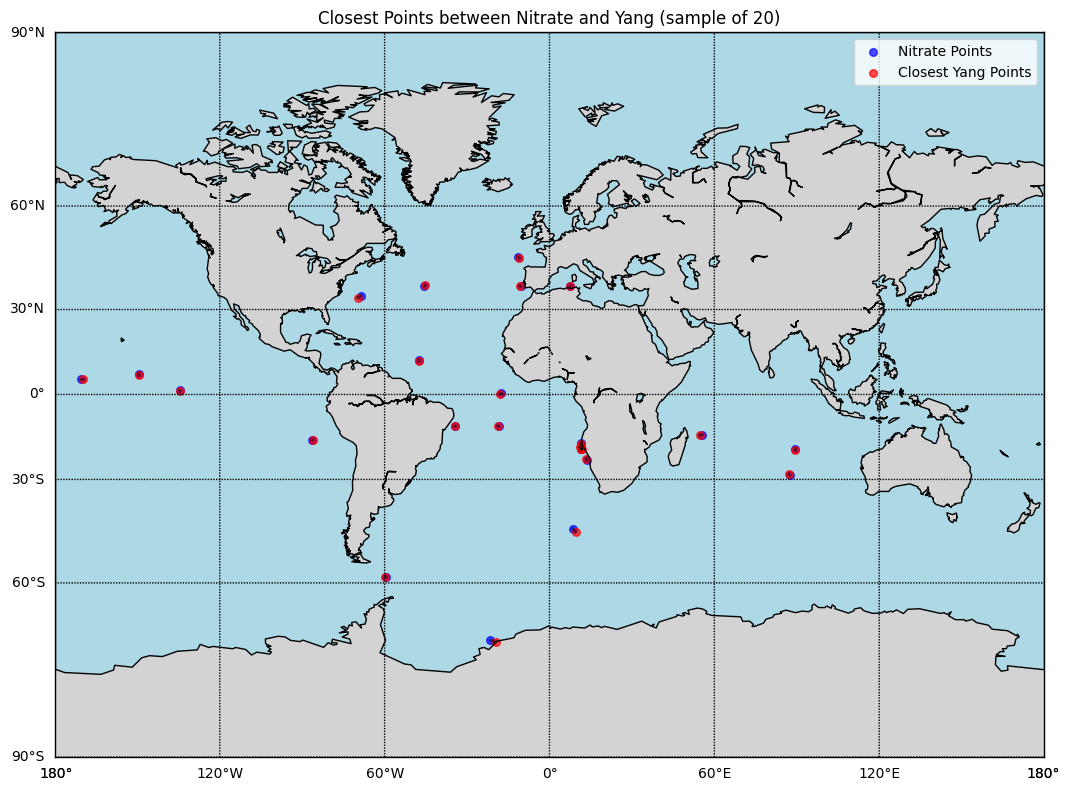

In [143]:
# Sample 20 random matched points from your DataFrame
np.random.seed(42)
idx = np.random.choice(len(closest), size=25, replace=False)
closest_sample = closest.iloc[idx]

plt.figure(figsize=(14, 8))

# Create Basemap instance
m = Basemap(projection='mill', lon_0=0)  # Use lon_0=0 for global view

# Draw map features
m.drawcoastlines()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0])
m.drawmeridians(range(-180, 181, 60), labels=[0,0,0,1])

# Transform coordinates to map projection
x_nitrate, y_nitrate = m(closest_sample['lon'].values, closest_sample['lat'].values)
x_yang, y_yang = m(closest_sample['yang_lon'].values, closest_sample['yang_lat'].values)

# Plot points
m.scatter(x_nitrate, y_nitrate, s=30, c='blue', alpha=0.7, label='Nitrate Points')
m.scatter(x_yang, y_yang, s=30, c='red', alpha=0.7, label='Closest Yang Points')

# Draw connecting lines
for i in range(len(closest_sample)):
    m.plot(
        [x_nitrate[i], x_yang[i]],
        [y_nitrate[i], y_yang[i]],
        color='black', linestyle='-', linewidth=2, alpha=0.5
    )

plt.title("Closest Points between Nitrate and Yang (sample of 20)")
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

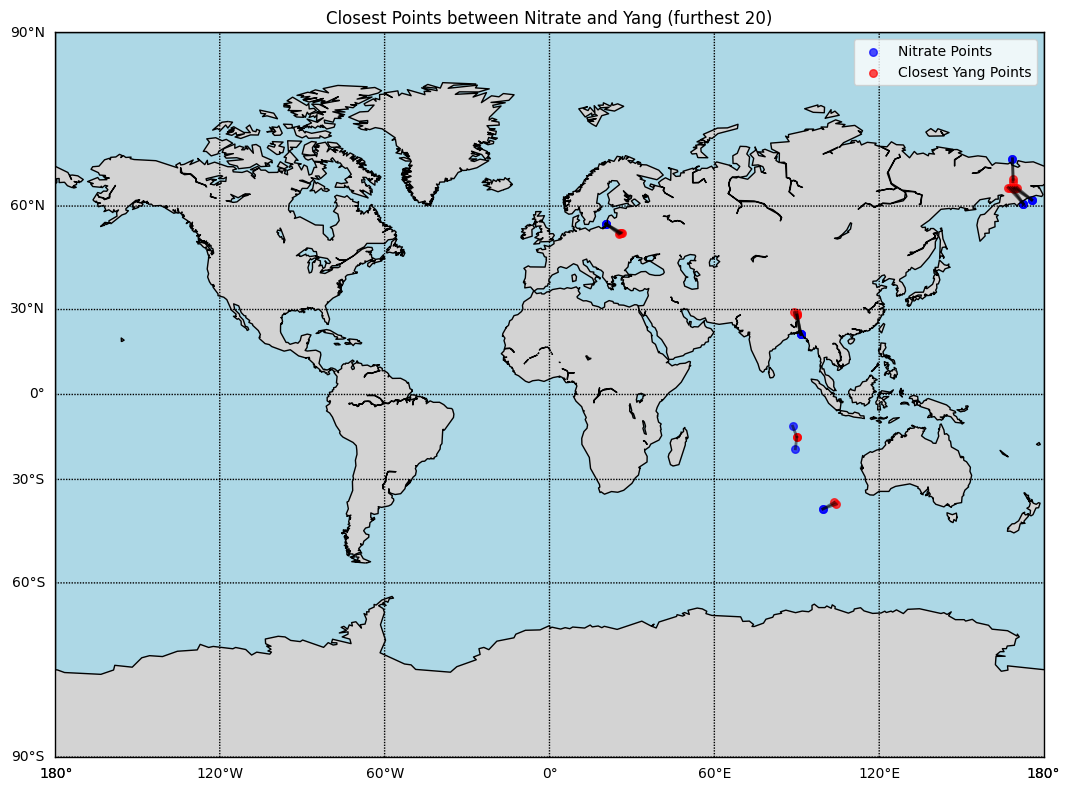

In [144]:
# plot the furthest points
furthest_points = closest.nlargest(20, 'distance_km')
plt.figure(figsize=(14, 8))

plt.figure(figsize=(14, 8))

# Create Basemap instance
m = Basemap(projection='mill', lon_0=0)  # Use lon_0=0 for global view

# Draw map features
m.drawcoastlines()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0])
m.drawmeridians(range(-180, 181, 60), labels=[0,0,0,1])

# Transform coordinates to map projection
x_nitrate, y_nitrate = m(furthest_points['lon'].values, furthest_points['lat'].values)
x_yang, y_yang = m(furthest_points['yang_lon'].values, furthest_points['yang_lat'].values)

# Plot points
m.scatter(x_nitrate, y_nitrate, s=30, c='blue', alpha=0.7, label='Nitrate Points')
m.scatter(x_yang, y_yang, s=30, c='red', alpha=0.7, label='Closest Yang Points')

# Draw connecting lines
for i in range(len(furthest_points)):
    m.plot(
        [x_nitrate[i], x_yang[i]],
        [y_nitrate[i], y_yang[i]],
        color='black', linestyle='-', linewidth=2, alpha=0.5
    )

plt.title("Closest Points between Nitrate and Yang (furthest 20)")
plt.legend()
plt.tight_layout()
plt.show()

## Making the grid

In [12]:
df_woa, ds_woa = process_woa_grid()

Loading .parquet file...
Inputting NaNs...
Smoothing 2D field...
Interpolating values...


Interpolating phosphate_00: 100%|██████████| 57/57 [01:17<00:00,  1.35s/it]


Converting to Dataframe...
Done!


Data shape: (721, 1441), NaNs: 77608 (7.47%)


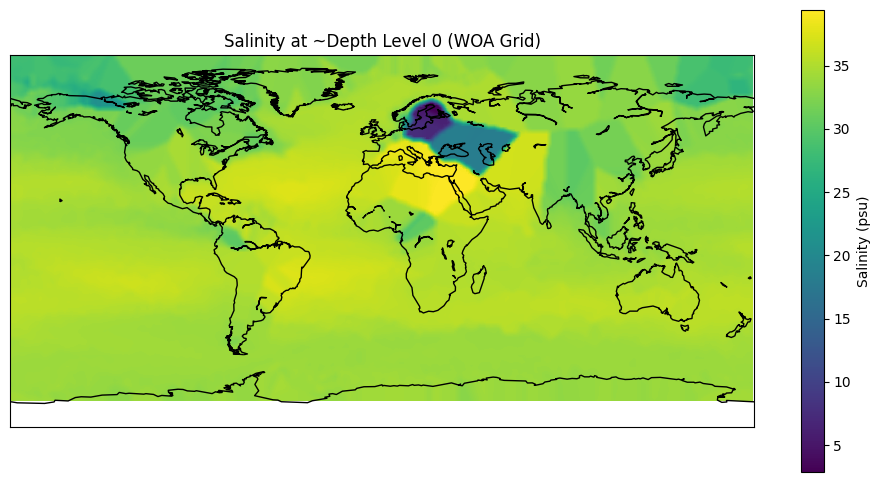

In [13]:
# Mask NaNs (this creates a masked array where NaNs are treated as missing)
data_pre = ds_woa.salinity_00.isel(depth=0).values
data = np.ma.masked_invalid(ds_woa.salinity_00.isel(depth=0).values)
print(f"Data shape: {data_pre.shape}, NaNs: {np.isnan(data_pre).sum()} ({np.isnan(data_pre).mean() * 100:.2f}%)")

# Plot
plt.figure(figsize=(12, 6))
m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='c')

m.drawcoastlines()
# m.drawmapboundary(fill_color='lightblue')
# m.fillcontinents(color='lightgray', lake_color='lightblue')

# Coordinate grid
lon2d, lat2d = np.meshgrid(ds_woa.lon, ds_woa.lat)
x, y = m(lon2d, lat2d)

# Plot with transparency for NaNs
c = m.pcolormesh(x, y, data, shading='auto', cmap='viridis', alpha=1.0)

plt.colorbar(c, label='Salinity (psu)')
plt.title('Salinity at ~Depth Level 0 (WOA Grid)')
plt.show()

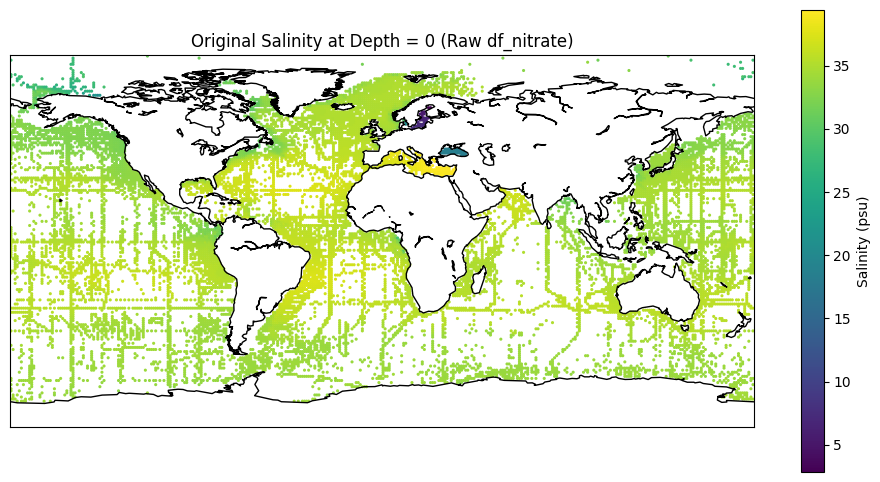

In [14]:
# Filter original nitrate data at depth == 0
df_slice = df_nitrate[df_nitrate['depth'] == 0]

# Drop rows with missing salinity
df_slice = df_slice.dropna(subset=['salinity_00'])

# Extract coordinates and values
lats = df_slice['lat'].values
lons = df_slice['lon'].values
salinity = df_slice['salinity_00'].values

# Plot
plt.figure(figsize=(12, 6))
m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='c')

m.drawcoastlines()
# m.drawmapboundary(fill_color='lightblue')
# m.fillcontinents(color='lightgray', lake_color='lightblue')

# Project coordinates
x, y = m(lons, lats)

# Use scatter plot for point data
sc = m.scatter(x, y, c=salinity, s=5, cmap='viridis', edgecolors='none')

# Add colorbar and title
plt.colorbar(sc, label='Salinity (psu)')
plt.title('Original Salinity at Depth = 0 (Raw df_nitrate)')
plt.show()

## Save the grid

In [198]:
ds_woa

<xarray.Dataset> Size: 2GB
Dimensions:         (depth: 57, lat: 721, lon: 1441)
Coordinates:
  * depth           (depth) int64 456B 0 5 10 15 20 ... 1300 1350 1400 1450 1500
  * lat             (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon             (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.8 180.0
Data variables:
    temperature_00  (depth, lat, lon) float64 474MB nan nan nan ... nan nan nan
    salinity_00     (depth, lat, lon) float64 474MB nan nan nan ... nan nan nan
    oxygen_00       (depth, lat, lon) float64 474MB nan nan nan ... nan nan nan
    nitrate_00      (depth, lat, lon) float64 474MB nan nan nan ... nan nan nan
    phosphate_00    (depth, lat, lon) float64 474MB nan nan nan ... nan nan nan

In [ ]:
# dataframe of the final grid
df_woa = ds_woa.to_dataframe().reset_index()

In [200]:
df_woa.head()

,depth,lat,lon,temperature_00,salinity_00,oxygen_00,nitrate_00,phosphate_00
0,0,-90.0,-180.00,NaN,NaN,NaN,NaN,NaN
1,0,-90.0,-179.75,NaN,NaN,NaN,NaN,NaN
2,0,-90.0,-179.50,NaN,NaN,NaN,NaN,NaN
3,0,-90.0,-179.25,NaN,NaN,NaN,NaN,NaN
4,0,-90.0,-179.00,NaN,NaN,NaN,NaN,NaN


In [ ]:
# watch out: huge file!
# df_woa.to_csv('data/processed/woa_grid.csv')

In [39]:
df_woa_shallow = ds_woa.isel(depth=0).to_dataframe().reset_index()
df_woa_shallow.head()

,lat,lon,temperature_00,salinity_00,oxygen_00,nitrate_00,phosphate_00,depth
0,-90.0,-180.00,NaN,NaN,NaN,NaN,NaN,0
1,-90.0,-179.75,NaN,NaN,NaN,NaN,NaN,0
2,-90.0,-179.50,NaN,NaN,NaN,NaN,NaN,0
3,-90.0,-179.25,NaN,NaN,NaN,NaN,NaN,0
4,-90.0,-179.00,NaN,NaN,NaN,NaN,NaN,0


In [40]:
df_woa_shallow.to_csv('data/processed/woa_grid_shallow.csv', index=False)

## Join the datasets

In [7]:
PATH = 'data/processed/woa_grid_shallow.csv'

In [8]:
df_woa_shallow = pd.read_csv(PATH)

In [12]:
# for each lat, lon take the shallowest row
df_yang_shallow = df_yang.loc[df_yang.groupby(['lat', 'lon'])['depth'].idxmin()]

In [17]:
df_joined = find_closest_points_on_grid(df_yang_shallow, df_woa_shallow)
df_joined.head()

,lat_yang,lon_yang,depth_yang,n2o_ppb,n2o_nM,dn2o_ppb,atmPressure,salinity,lat_woa,lon_woa,temperature_00,salinity_00,oxygen_00,nitrate_00,phosphate_00,depth_woa
0,-77.177,-33.960,5.0,341.0,15.849643,33.91172,0.963031,34.411179,-77.25,-34.0,-1.754778,34.057472,358.441167,17.018,1.119389,0
1,-77.173,-33.955,5.0,336.1,15.621912,29.01172,0.963033,34.411388,-77.25,-34.0,-1.754778,34.057472,358.441167,17.018,1.119389,0
2,-77.173,-33.892,5.0,336.6,15.569799,29.51752,0.946758,34.412918,-77.25,-34.0,-1.754778,34.057472,358.441167,17.018,1.119389,0
3,-77.172,-33.908,5.0,335.7,15.528497,28.61752,0.946736,34.412552,-77.25,-34.0,-1.754778,34.057472,358.441167,17.018,1.119389,0
4,-77.172,-33.902,5.0,333.5,15.426613,26.41752,0.946586,34.412697,-77.25,-34.0,-1.754778,34.057472,358.441167,17.018,1.119389,0


In [14]:
print(len(df_yang_shallow))
print(len(df_woa_shallow))
print(len(df_joined))

128559
1038961
128559


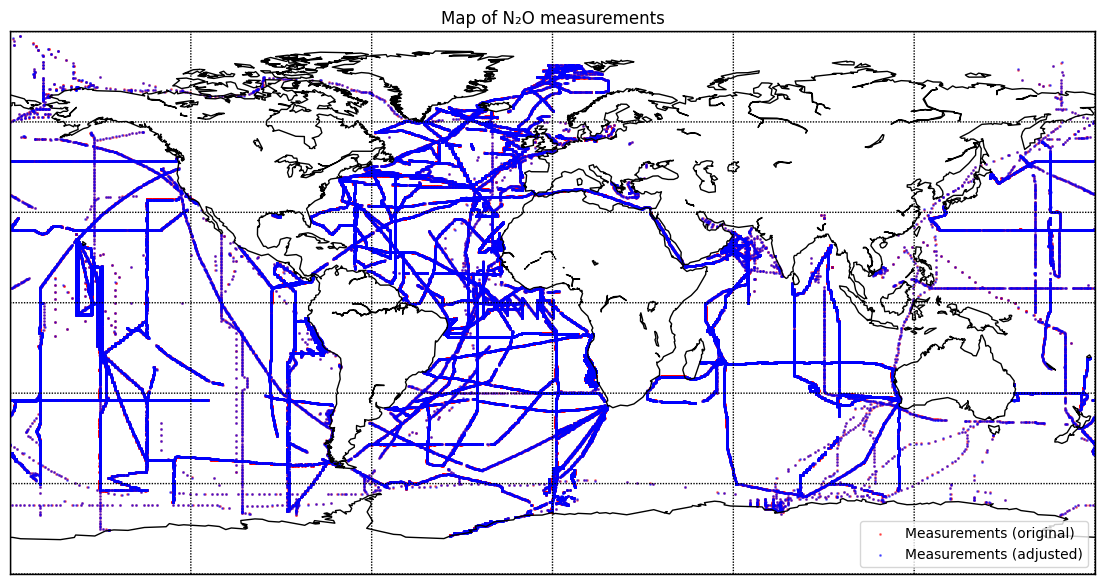

In [15]:
plt.figure(figsize=(14, 8))
m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='c')
m.drawcoastlines()
m.drawmapboundary()
m.drawparallels(range(-90, 91, 30))
m.drawmeridians(range(-180, 181, 60))
x, y = m(df_yang["lon"].values, df_yang["lat"].values)
m.scatter(x, y, s=1, c='red', alpha=0.5, label='Measurements (original)')

x1, y1 = m(df_joined["lon_woa"].values, df_joined["lat_woa"].values)
m.scatter(x1, y1, s=1, c='blue', alpha=0.5, label='Measurements (adjusted)')


plt.title("Map of N₂O measurements")
plt.legend()
plt.show()

In [20]:
df_joined.to_csv('data/processed/yang_woa_grid_shallow.csv', index=False)

In [18]:
df_joined.head()

,lat_yang,lon_yang,depth_yang,n2o_ppb,n2o_nM,dn2o_ppb,atmPressure,salinity,lat_woa,lon_woa,temperature_00,salinity_00,oxygen_00,nitrate_00,phosphate_00,depth_woa
0,-77.177,-33.960,5.0,341.0,15.849643,33.91172,0.963031,34.411179,-77.25,-34.0,-1.754778,34.057472,358.441167,17.018,1.119389,0
1,-77.173,-33.955,5.0,336.1,15.621912,29.01172,0.963033,34.411388,-77.25,-34.0,-1.754778,34.057472,358.441167,17.018,1.119389,0
2,-77.173,-33.892,5.0,336.6,15.569799,29.51752,0.946758,34.412918,-77.25,-34.0,-1.754778,34.057472,358.441167,17.018,1.119389,0
3,-77.172,-33.908,5.0,335.7,15.528497,28.61752,0.946736,34.412552,-77.25,-34.0,-1.754778,34.057472,358.441167,17.018,1.119389,0
4,-77.172,-33.902,5.0,333.5,15.426613,26.41752,0.946586,34.412697,-77.25,-34.0,-1.754778,34.057472,358.441167,17.018,1.119389,0
